##Importing the necessary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import numpy as np


##Importing the training images from directory

In [2]:
train_dataset = r'/content/drive/MyDrive/X_rays_Dataset/TRAIN'
categories = ['Lungs Disease','Normal']
data_1 =[]
IMZ_SIZE = 180
for category in categories:
  folder_1 = os.path.join(train_dataset,category)
  label_1 = categories.index(category)
  for imz in os.listdir(folder_1):
    imz_join = os.path.join(folder_1,imz)
    imz_read = cv2.imread(imz_join)
    imz_resize = cv2.resize(imz_read,(IMZ_SIZE,IMZ_SIZE))
    data_1.append([imz_resize,label_1])

##Importing the test images from directory

In [3]:
test_dataset = r'/content/drive/MyDrive/X_rays_Dataset/TEST'
data_2 = []
for category in categories:
  folder_2 = os.path.join(test_dataset,category)
  label_2 = categories.index(category)
  for imz_1 in os.listdir(folder_2):
    imz_join2 = os.path.join(folder_2,imz_1)
    imz_read2 = cv2.imread(imz_join2)
    imz_resize1 = cv2.resize(imz_read2,(IMZ_SIZE,IMZ_SIZE))
    data_2.append([imz_resize1,label_2])

##Extracting features and labels from training data

In [4]:
#for training data
import random
random.shuffle(data_1)

In [5]:
import numpy as np
X_train = []
Y_train = []
for features,labels in data_1:
  X_train.append(features)
  Y_train.append(labels)
X_train = np.array(X_train)
Y_train = np.array(Y_train)


###reshaping the label of training data

In [6]:
Y_train_reshape = Y_train.reshape(len(Y_train),1*1)
Y_train_reshape[:5]

array([[0],
       [0],
       [0],
       [1],
       [0]])

In [7]:
Y_train_categorical = keras.utils.to_categorical(Y_train_reshape,num_classes=2,dtype='float32')
Y_train_categorical[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

##Extracting features and labels from test data

In [8]:
random.shuffle(data_2)

In [9]:
X_test = []
Y_test = []
for features,labels in data_2:
  X_test.append(features)
  Y_test.append(labels)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [10]:
Y_test_reshape = Y_test.reshape(len(Y_test),1*1)
Y_test_categorical = keras.utils.to_categorical(Y_test_reshape,num_classes=2,dtype='float32')


##Looking the images

In [17]:
from matplotlib import pyplot as plt

In [ ]:
def plot_sample(X,Y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(X[index])
  plt.xlabel(categories[Y[index]])


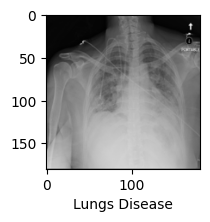

In [ ]:
plot_sample(X_train,Y_train,1)

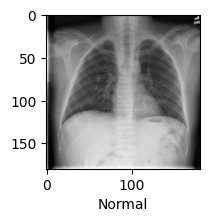

In [ ]:
plot_sample(X_train,Y_train,2)

##Transfer learning
###Using pretrained model like VGG16,VGG19,ResNet50 etc.

####Importing VGG19 model from keras

In [11]:
from keras.applications.vgg19 import VGG19

####Assign the same weights to VGG19 which was during the training on imagenet data.

In [12]:
conv_base = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(180,180,3)
)

80134624/80134624 [==============================] - 1s 0us/step


####Visualising the layers of VGG19 model

In [ ]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
from keras.utils import plot_model

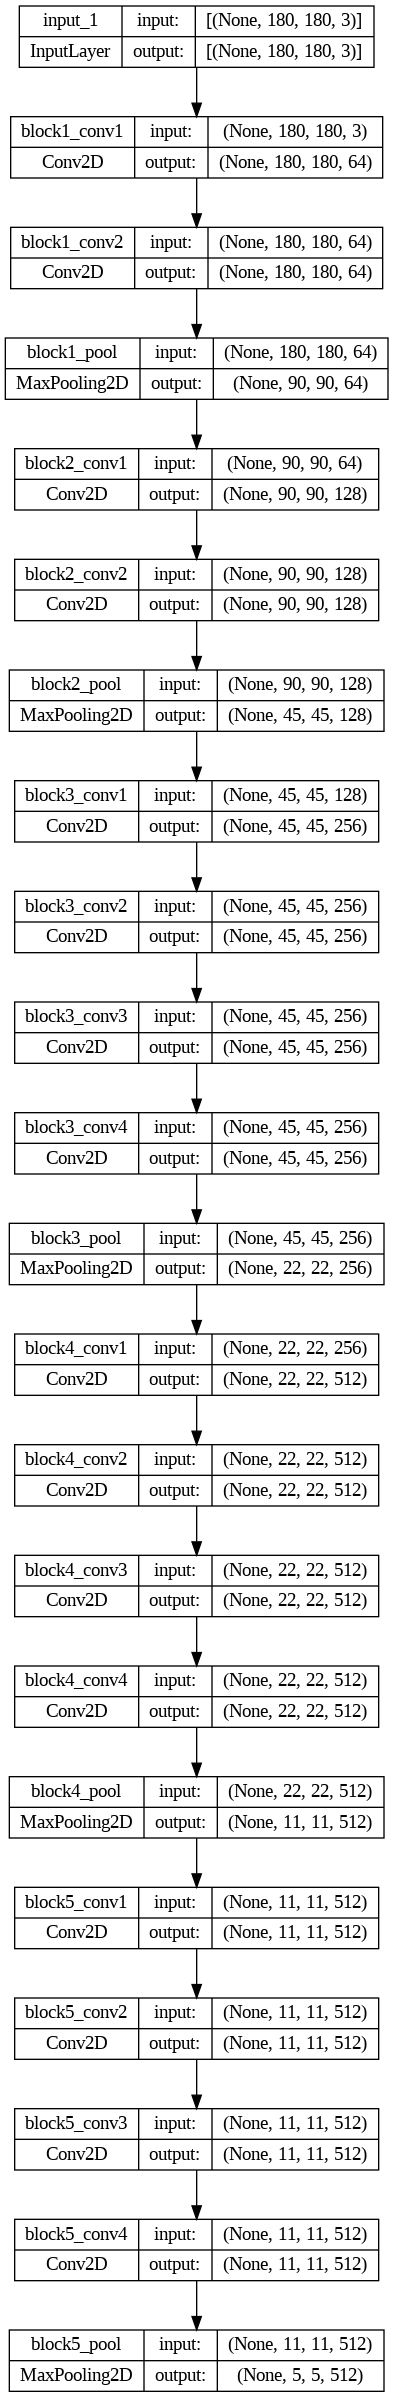

In [ ]:
plot_model(conv_base,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.6 MB/s eta 0:00:00


In [ ]:
import visualkeras

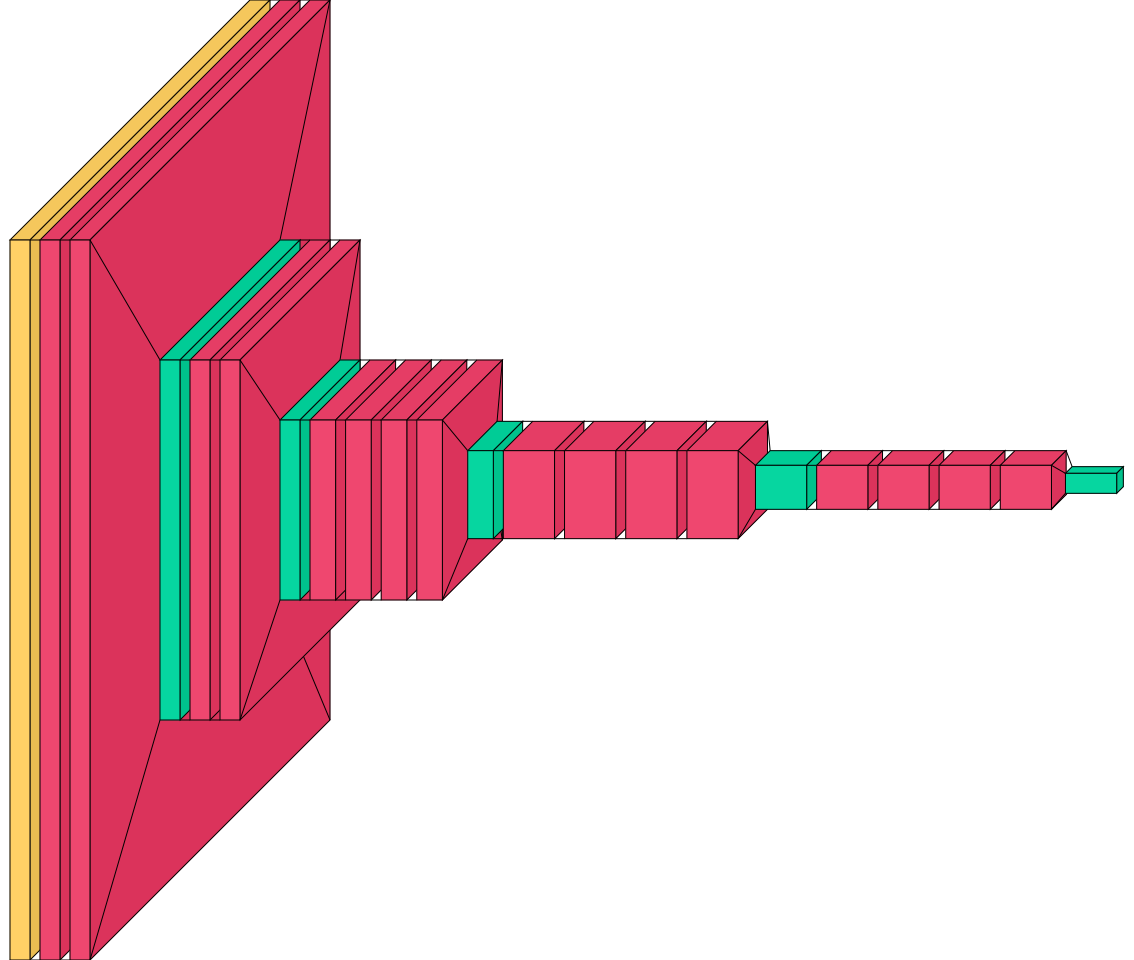

In [ ]:
visualkeras.layered_view(conv_base)

####Neural network in 2D or in flat style

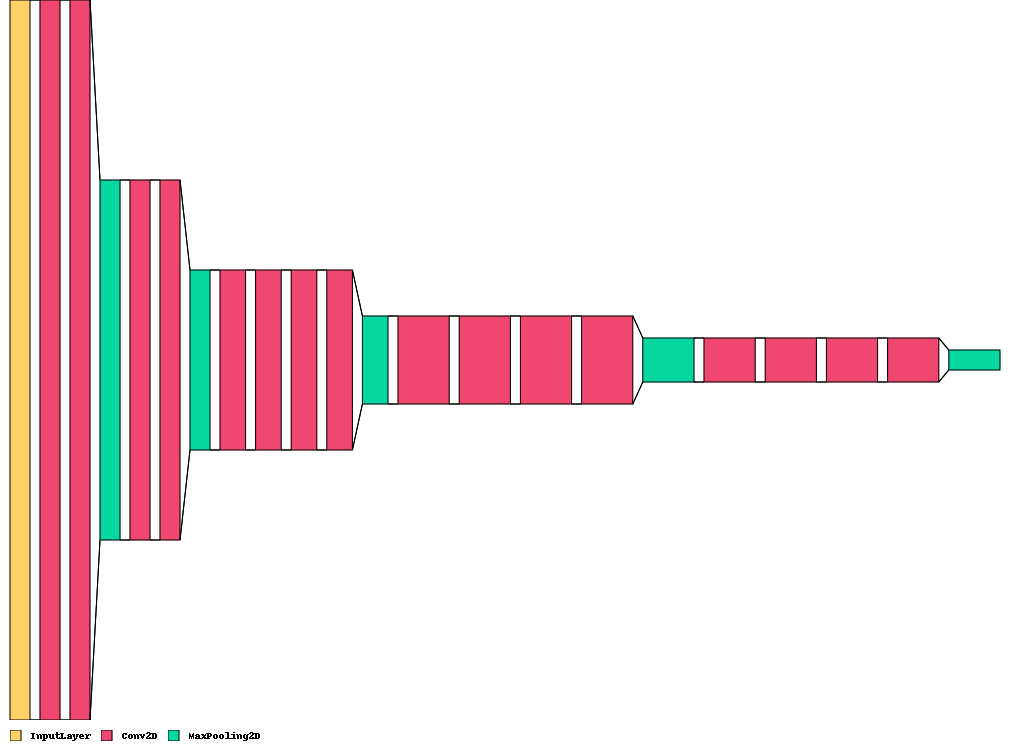

In [ ]:
visualkeras.layered_view(conv_base,legend=True,draw_volume=False)

####Building the ANN/Dense layer and adding the VGG19 on Dense layer.

In [13]:
model = keras.Sequential([
      conv_base,
      keras.layers.Flatten(),
      keras.layers.Dense(512,activation='relu'),
      keras.layers.Dense(300,activation='relu'),
      keras.layers.Dense(2,activation='softmax'),
])


###Visualising Dense layer


In [ ]:
visualkeras.layered_view(model)

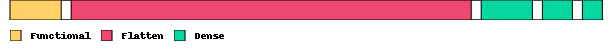

In [ ]:
visualkeras.layered_view(model,legend=True,draw_volume=False)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 512)               6554112   
                                                                 
 dense_1 (Dense)             (None, 300)               153900    
                                                                 
 dense_2 (Dense)             (None, 2)                 602       
                                                                 
Total params: 26732998 (101.98 MB)
Trainable params: 26732998 (101.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##Fine tunning
###Unfreeze some bottom layers of VGG19 model and rerun.

In [14]:
for layer in conv_base.layers:
  if layer.name.startswith('conv_5_block') or layer.name.startswith('conv_5_block2') or layer.name.startswith('conv_5_block3'):
    layer.trainable=True
  else:
    layer.trainable=False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 512)               6554112   
                                                                 
 dense_1 (Dense)             (None, 300)               153900    
                                                                 
 dense_2 (Dense)             (None, 2)                 602       
                                                                 
Total params: 26732998 (101.98 MB)
Trainable params: 6708614 (25.59 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


##Generating Images
###used to generate images if you have less number of images for training.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

###Generating images for training data

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
)

###Rescaling the test data

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

###Importing the training data from directory

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/X_rays_Dataset/TRAIN',
    target_size=(180,180),
    batch_size=5,
    class_mode='categorical',
)

Found 16204 images belonging to 2 classes.


###Importing the test data from directory

In [ ]:
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/X_rays_Dataset/TEST',
    target_size=(180,180),
    batch_size=5,
    class_mode='categorical',
)

Found 3388 images belonging to 2 classes.


##Checking the accuracy of the model

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,Y_train_categorical,validation_data=(X_test,Y_test_categorical),epochs=25,batch_size=5)

Epoch 1/25
3241/3241 [==============================] - 131s 37ms/step - loss: 0.6577 - accuracy: 0.8789 - val_loss: 0.2113 - val_accuracy: 0.9156
Epoch 2/25
3241/3241 [==============================] - 123s 38ms/step - loss: 0.2379 - accuracy: 0.9171 - val_loss: 0.1641 - val_accuracy: 0.9398
Epoch 3/25
3241/3241 [==============================] - 123s 38ms/step - loss: 0.1901 - accuracy: 0.9325 - val_loss: 0.1695 - val_accuracy: 0.9368
Epoch 4/25
3241/3241 [==============================] - 121s 37ms/step - loss: 0.1705 - accuracy: 0.9413 - val_loss: 0.1326 - val_accuracy: 0.9587
Epoch 5/25
3241/3241 [==============================] - 122s 38ms/step - loss: 0.1482 - accuracy: 0.9484 - val_loss: 0.1064 - val_accuracy: 0.9696
Epoch 6/25
3241/3241 [==============================] - 120s 37ms/step - loss: 0.1292 - accuracy: 0.9556 - val_loss: 0.1025 - val_accuracy: 0.9720
Epoch 7/25
3241/3241 [==============================] - 121s 37ms/step - loss: 0.1155 - accuracy: 0.9608 - val_loss: 0

##Plotting the model accuracy and loss

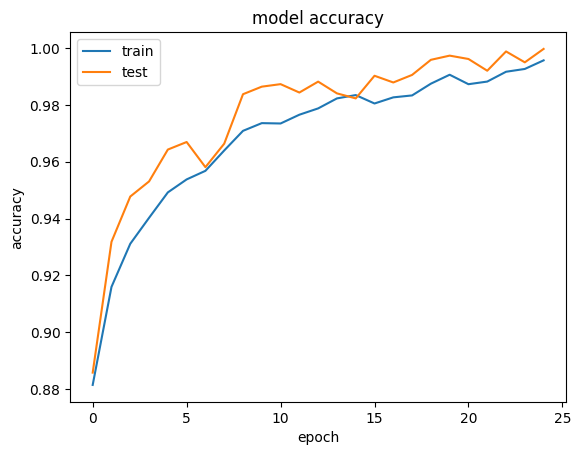

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

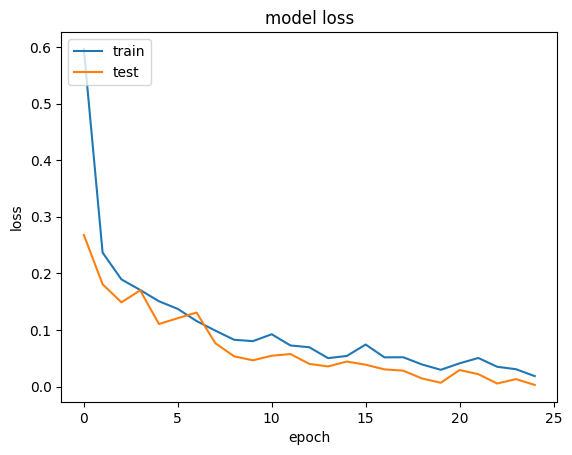

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

##Plotting confusion matrix and recall

In [20]:
y_pred = model.predict(X_test).round(2)

106/106 [==============================] - 18s 141ms/step


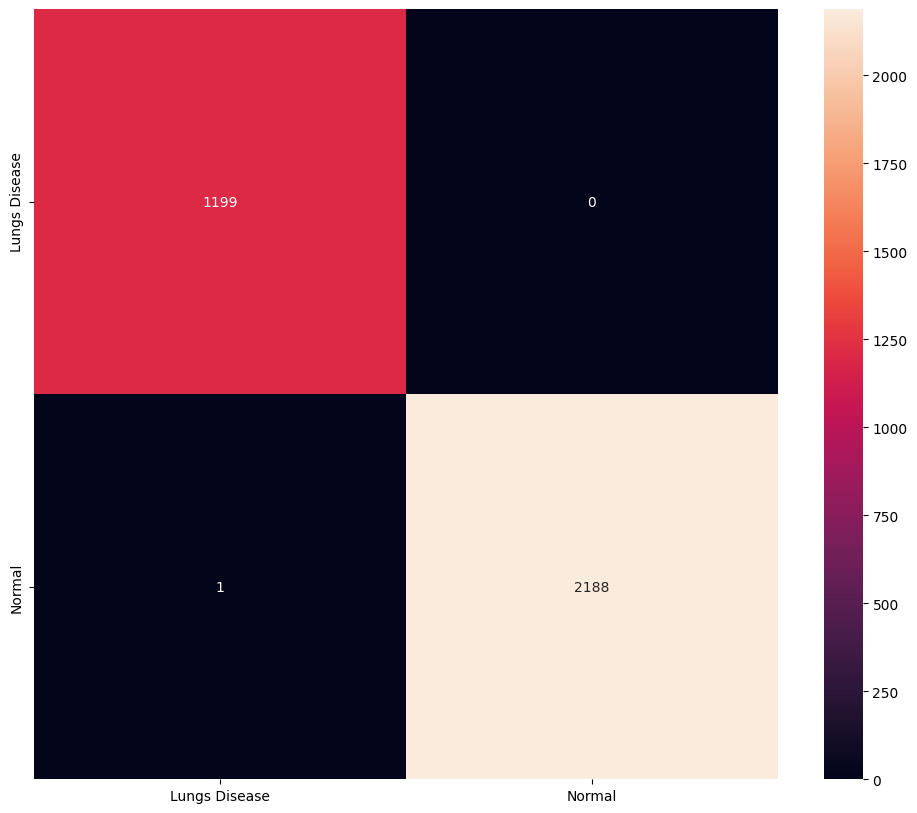

In [25]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(12,10))
y_pred_labels = [np.argmax(label) for label in y_pred]
cm = confusion_matrix(Y_test,y_pred_labels)
sns.heatmap(cm,annot=True,fmt='d',xticklabels=categories,yticklabels=categories)
plt.show()

In [24]:
from sklearn.metrics import classification_report
cr = classification_report(Y_test,y_pred_labels,target_names=categories)
print(cr)

               precision    recall  f1-score   support

Lungs Disease       1.00      1.00      1.00      1199
       Normal       1.00      1.00      1.00      2189

     accuracy                           1.00      3388
    macro avg       1.00      1.00      1.00      3388
 weighted avg       1.00      1.00      1.00      3388



In [ ]:
input_image = input('Enter the path of image:')
input_path = cv2.imread(input_image)
input_resize = cv2.resize(input_path,(180,180))
input_reshape = input_resize.reshape(1,180,180,3)
print(categories[np.argmax(model.predict(input_reshape))])



In [ ]:
model.save('/content/drive/MyDrive/saved model/model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/saved model/model.h5')
loaded_model.load_weights('/content/drive/MyDrive/saved model/model.h5')
categories = ['Lungs Disease','Normal']

In [ ]:
input_image = input('Enter the path of image:')
input_path = cv2.imread(input_image)
input_resize = cv2.resize(input_path,(180,180))
input_reshape = input_resize.reshape(1,180,180,3)
print(categories[np.argmax(loaded_model.predict(input_reshape))])


Enter the path of image:/content/drive/MyDrive/D6.jpg
1/1 [==============================] - 0s 19ms/step
Lungs Disease
